In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# ========================= 0. Import =========================
import os, cv2, numpy as np, torch, matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from collections import Counter
from sklearn.neighbors import KernelDensity   # KDE
from tqdm import tqdm

# ========================= 1. Thông số =========================
DATA_DIR = "../dataset/Soil"
IMG_SIZE   = 64
AUG_FACTOR = 5
BINS       = 64           # vẫn giữ 32 “bin” để trực quan
N_JOBS     = -1           # dùng hết CPU cho KDE

# ========================= 2. Augmentation =========================
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
   #  transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),                               # về [0,1]
   #  transforms.Normalize(mean=[0.485, 0.456, 0.406],
   #                       std =[0.229, 0.224, 0.225])
])

# ========================= 3. Dataset =========================
original_ds = datasets.ImageFolder(DATA_DIR)
original_counts = Counter([lbl for _, lbl in original_ds])
print("📊 Số lượng mẫu GỐC theo lớp:")
for cls, cnt in original_counts.items():
    print(f"  {original_ds.classes[cls]}: {cnt}")

augmented_ds = ConcatDataset(
    [datasets.ImageFolder(DATA_DIR, transform=train_tf) for _ in range(AUG_FACTOR)]
)


📊 Số lượng mẫu GỐC theo lớp:
  Cinder Soil: 3
  Red Soil: 15


RGB-color-KDE:   0%|          | 0/90 [00:00<?, ?it/s]

RGB-color-KDE: 100%|██████████| 90/90 [00:22<00:00,  4.07it/s]


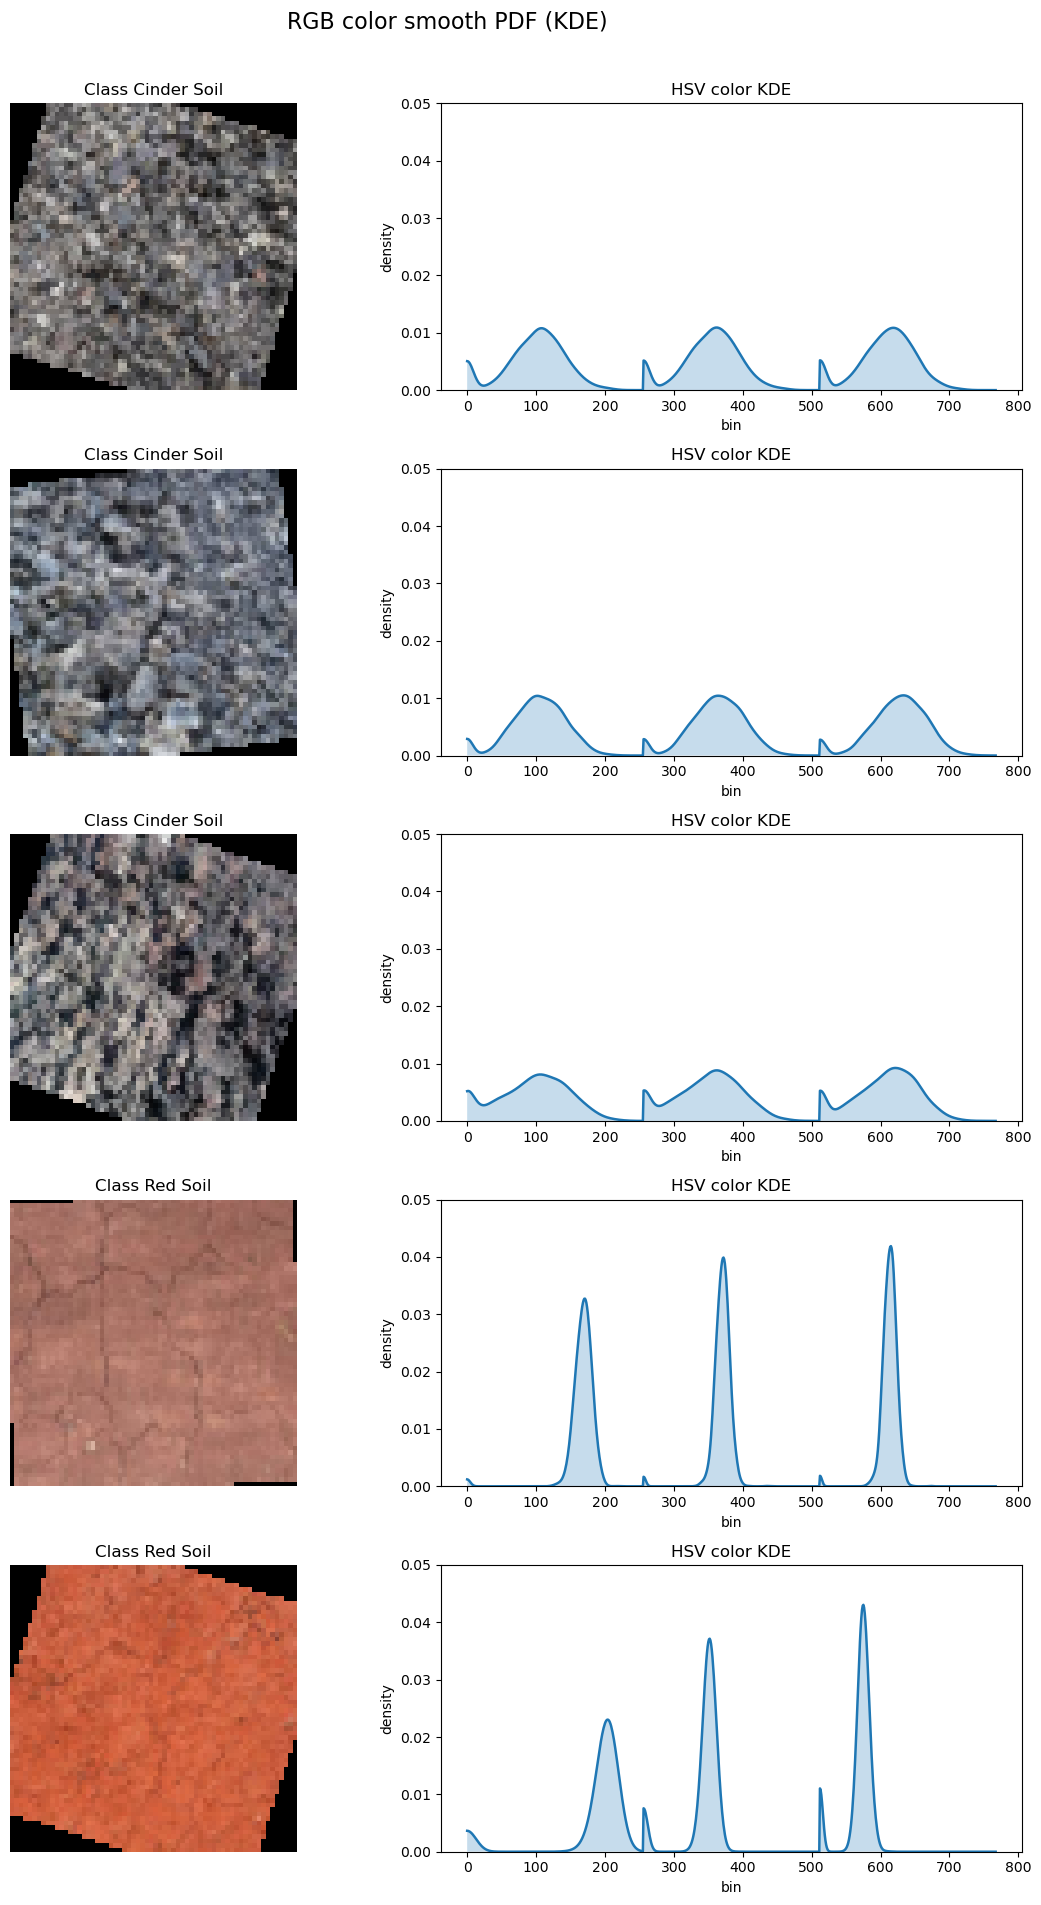

In [3]:
# ========================= 4bis. RGB-color KDE =========================
def rgb_color_kde(tensor_3hw, bins=256):
    """tensor_3hw: [3,H,W] /[0,1]  ->  RGB KDE vector (bins*3,)"""
    img = (tensor_3hw.permute(1,2,0)*255).clamp(0,255).byte().cpu().numpy()
    r,g,b = cv2.split(img)
    x_grid = np.linspace(0,255,bins).reshape(-1,1)
    full_dens = []
    for ch in (r,g,b):
        samples = ch.flatten().reshape(-1,1)
        bw = 1.06 * samples.size ** (-1/5) * np.std(samples)
        kde = KernelDensity(kernel='gaussian', bandwidth=bw)
        kde.fit(samples)
        dens = np.exp(kde.score_samples(x_grid))
        dens /= dens.sum()
        full_dens.append(dens)
    return np.concatenate(full_dens)   # (bins*3,)

# ========================= 5bis. Trích toàn bộ RGB-KDE =========================
rgb_kde_features, image_labels = [], []
for tens, lbl in tqdm(augmented_ds, desc="RGB-color-KDE"):
    rgb_kde_features.append(rgb_color_kde(tens))
    image_labels.append(lbl)
rgb_kde_features = np.array(rgb_kde_features)   # <- thay thế opponent_sift_kdes

# --------------- chỉ số mịn ---------------
SMOOTH_BINS = 256
num_plot   = min(5, len(rgb_kde_features))   # sửa tên biến
fig, axes  = plt.subplots(num_plot, 2, figsize=(12, 4*num_plot))
fig.suptitle("RGB color smooth PDF (KDE)", fontsize=16)


for i in range(num_plot):
    # --- ảnh RGB ---
    img_tensor = augmented_ds[i][0]        # [3,64,64] /[0,1]
    img = (img_tensor.permute(1,2,0)*255).clamp(0,255).byte().numpy()
    axes[i,0].imshow(img); axes[i,0].axis('off')
    axes[i,0].set_title(f"Class {original_ds.classes[image_labels[i]]}")

    # --- chuyển HSV và chia 3 kênh ---
   #  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img)

    # --- KDE cho từng kênh ---
    x_grid = np.linspace(0,255,SMOOTH_BINS)
    full_dens = []
    for ch, rng in zip((h,s,v), (180,256,256)):
        samples = ch.flatten().reshape(-1,1)
        # bw nhỏ vì data nhiều
        bw = 1.06 * samples.size ** (-1/5) * np.std(samples)
        kde = KernelDensity(kernel='gaussian', bandwidth=bw)
        kde.fit(samples)
        dens = np.exp(kde.score_samples(x_grid.reshape(-1,1)))
        dens /= dens.sum()
        full_dens.append(dens)

    full_dens = np.concatenate(full_dens)   # 3*SMOOTH_BINS
    axes[i,1].plot(np.arange(len(full_dens)), full_dens, lw=1.8)
    axes[i,1].fill_between(np.arange(len(full_dens)), full_dens, alpha=0.25)
    axes[i,1].set_title("HSV color KDE")
    axes[i,1].set_ylim(0, 0.05)
    axes[i,1].set_xlabel("bin"); axes[i,1].set_ylabel("density")

plt.tight_layout(rect=[0,0.03,1,0.97])
plt.show()

Gray-color-KDE:   0%|          | 0/90 [00:00<?, ?it/s]

Gray-color-KDE: 100%|██████████| 90/90 [00:08<00:00, 10.32it/s]


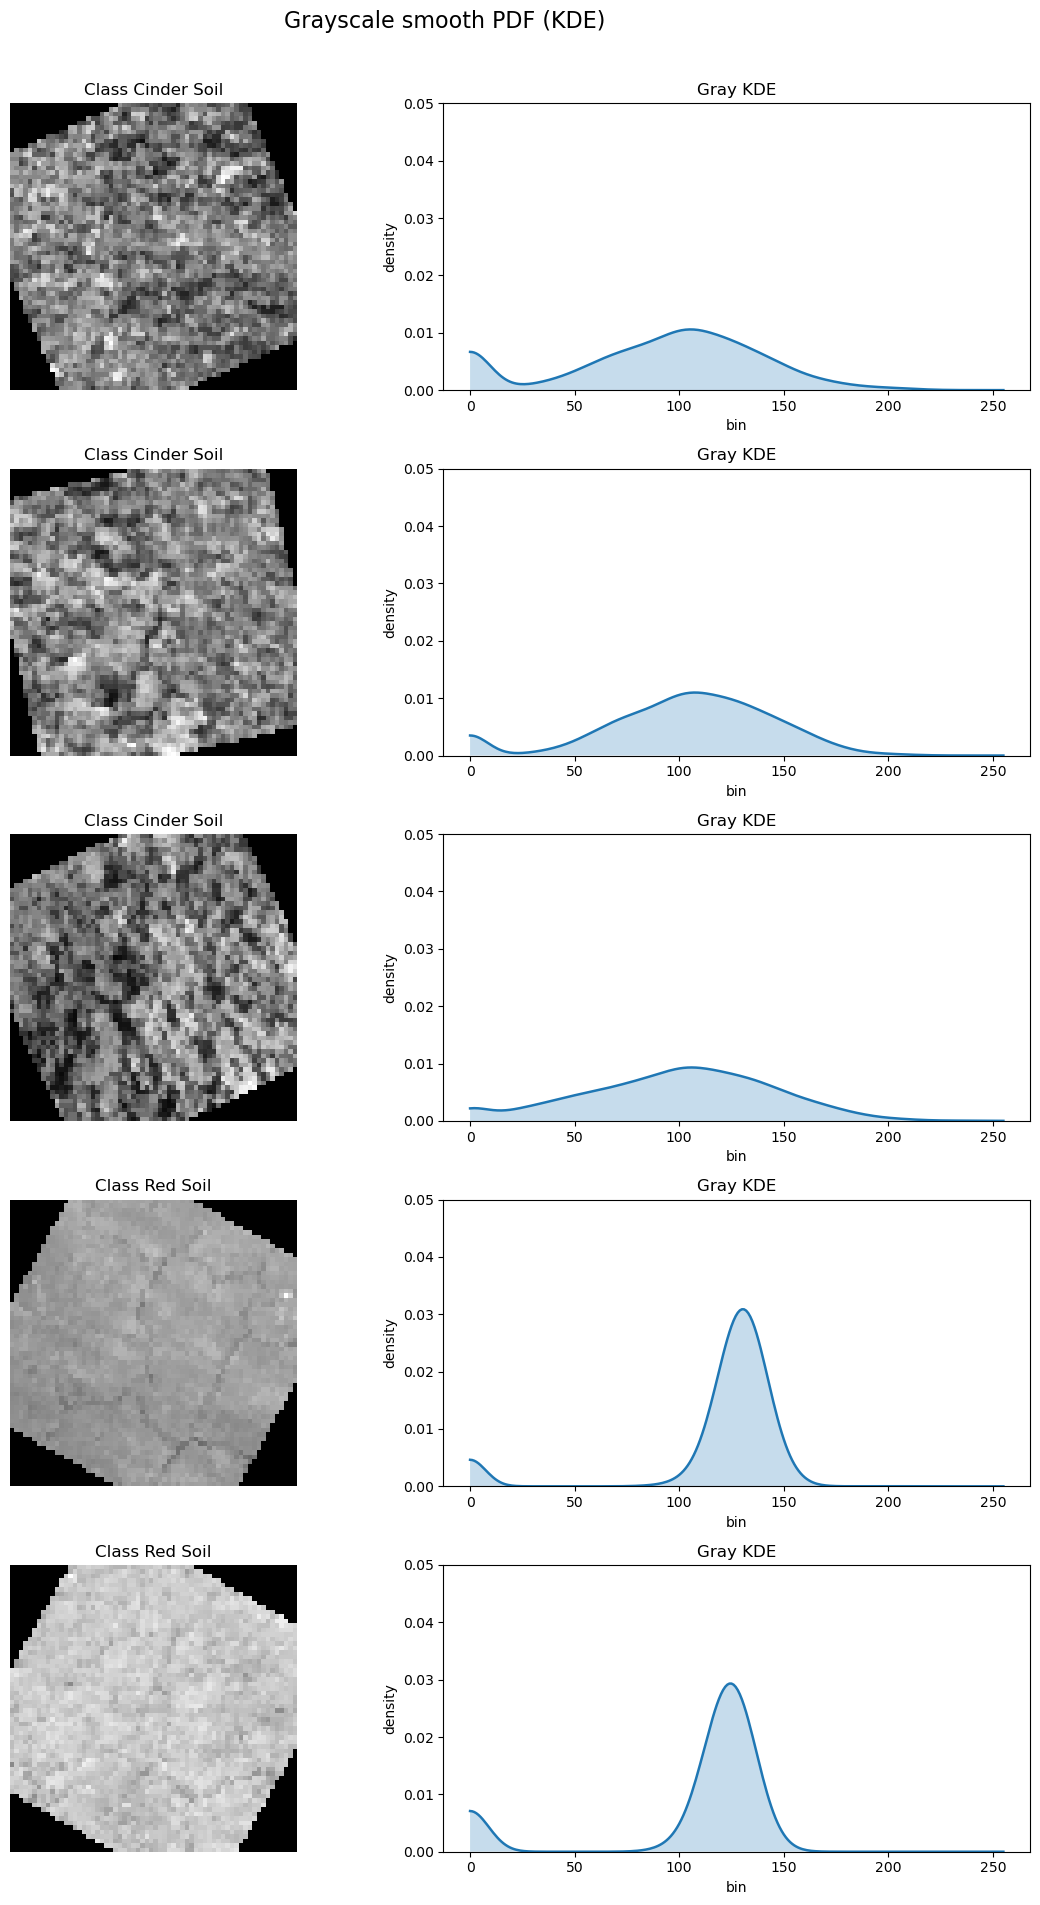

In [5]:
# ========================= 4bis. Gray-color KDE =========================
def gray_color_kde(tensor_3hw, bins=256):
    """tensor_3hw: [3,H,W] /[0,1]  ->  Gray KDE vector (bins,)"""
    img = (tensor_3hw.permute(1,2,0)*255).clamp(0,255).byte().cpu().numpy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        # <--- chuyển Gray
    x_grid = np.linspace(0,255,bins).reshape(-1,1)
    samples = gray.flatten().reshape(-1,1)
    bw = 1.06 * samples.size ** (-1/5) * np.std(samples)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(samples)
    dens = np.exp(kde.score_samples(x_grid))
    dens /= dens.sum()
    return dens.ravel()   # (bins,)

# ========================= 5bis. Trích toàn bộ Gray-KDE =========================
gray_kde_features, image_labels = [], []
for tens, lbl in tqdm(augmented_ds, desc="Gray-color-KDE"):
    gray_kde_features.append(gray_color_kde(tens))
    image_labels.append(lbl)
gray_kde_features = np.array(gray_kde_features)   # shape: (N, bins)

# --------------- chỉ số mịn ---------------
SMOOTH_BINS = 256
num_plot   = min(5, len(gray_kde_features))
fig, axes  = plt.subplots(num_plot, 2, figsize=(12, 4*num_plot))
fig.suptitle("Grayscale smooth PDF (KDE)", fontsize=16)

for i in range(num_plot):
    # --- ảnh Gray ---
    img_tensor = augmented_ds[i][0]
    img = (img_tensor.permute(1,2,0)*255).clamp(0,255).byte().numpy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    axes[i,0].imshow(gray, cmap='gray'); axes[i,0].axis('off')
    axes[i,0].set_title(f"Class {original_ds.classes[image_labels[i]]}")

    # --- Gray KDE ---
    full_dens = gray_kde_features[i]   # đã tính sẵn
    axes[i,1].plot(full_dens, lw=1.8)
    axes[i,1].fill_between(np.arange(len(full_dens)), full_dens, alpha=0.25)
    axes[i,1].set_title("Gray KDE")
    axes[i,1].set_xlabel("bin"); axes[i,1].set_ylabel("density")
    axes[i,1].set_ylim(0, 0.05)

plt.tight_layout(rect=[0,0.03,1,0.97])
plt.show()